# Introduction

In this notebook we demonstrate the use of LSI (Latent Semantic Indexing) Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import pprint

import matplotlib.pyplot as plt

## Load Dataset and Preprocessing

In [2]:
trace_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
artfs_desc_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name


# LSI Model

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, pairwise_distances, pairwise
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import datetime

import warnings; warnings.simplefilter('ignore')

class LSI:
    def __init__(self):
        self.name = "LSI"
        self.min_cosine_similarity_threshold = .80
        self._svd_matrix = None
        self._query_vector = None
        self.trace_links_df = None
        
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                             use_idf=True, 
                                             smooth_idf=True)
        
        self.svd_model = TruncatedSVD(n_components = 100, 
                                         algorithm = 'randomized',
                                         n_iter = 10, 
                                         random_state = 42)
                  
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        svd_transformer = Pipeline([('tfidf', self.vectorizer), 
                            ('svd', self.svd_model)])

        self._svd_matrix = svd_transformer.fit_transform(corpus)
        self._query_vector = svd_transformer.transform(query)
        
        # D 14 x 10
        self._cosine_sim_matrix = pairwise.cosine_similarity(self._svd_matrix,
                                                            self._query_vector)
        
        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                           columns = bug_reports_names,
                                           data = self._cosine_sim_matrix)

        for col in self.trace_links_df.columns:
            self.trace_links_df[col] = [1 if x >= self.min_cosine_similarity_threshold else 0 for x in self.trace_links_df[col]]

    def model_setup(self):
        return {"Setup" : 
                  [
                      {"LSI Minimum Cosine Similarity Threshold" : self.min_cosine_similarity_threshold},
                      {"SVD Model" : self.svd_model.get_params()},
                      {"Vectorizer" : self.vectorizer.get_params()},
                      {"Vectorizer Type" : type(self.vectorizer)}
                  ]
               }
    
    def get_cosine_sim_matrix(self):
        return self._cosine_sim_matrix
    
    def get_query_vector(self):
        return self._query_vector
    
    def get_svd_matrix(self):
        return self._svd_matrix

class OracleLoader:
    def __init__(self, rows_names, columns_names):
        self.oracle = None
        self._columns_names = columns_names
        self._rows_names = rows_names
    
    def load(self):
        self.oracle = pd.DataFrame(columns=list(self._columns_names))
        self.oracle.insert(0, 'artf_name', list(self._rows_names))
        
        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

        
class ModelEvaluator:
    def __init__(self, oracle, model):
        self.model = model
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
        self.mean_precision = -1
        self.mean_recall = -1
        self.mean_fscore = -1
    
    def evaluate_model(self, verbose=False, file=None):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in self.oracle.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1
        
        self.mean_precision = self.eval_df.precision.mean()
        self.mean_recall = self.eval_df.recall.mean()
        self.mean_fscore = self.eval_df.fscore.mean()
        
        if verbose:
            self.print_report(file)
    
    def print_report(self, file=None):
        dic = self.model.model_setup()
        dic['Measures'] = {}
        dic['Measures']['Mean Precision of {}'.format(self.model.name)] = self.mean_precision
        dic['Measures']['Mean Recall of {}'.format(self.model.name)] = self.mean_recall
        dic['Measures']['Mean FScore of {}'.format(self.model.name)] = self.mean_fscore
        
        if file is None:    
            pprint.pprint(dic)
        else:
            file.write(pprint.pformat(dic))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(6,6))
        plt.plot(self.eval_df.recall, self.eval_df.precision, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.show()
    
    def save_log(self):
        with open('logs/' + str(datetime.datetime.now()) + '.txt', 'a') as f:
            evaluator.evaluate_model(verbose=True, file=f)

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

In [4]:
orc = OracleLoader(use_cases_names, bug_reports_names)
orc.load()

In [ ]:
params_dict = {
    'lsi__min_cosine_similarity_threshold' : .9,
    'lsi__name' : 'LSI',
    'lsi__vectorizer' : Vectorizer(),
    'lsi__vectorizer__stop_words' : 'english',
    'lsi__vectorizer__use_idf' : True,     # optional if type(Vectorizer) == TfidfVectorizer
    'lsi__vectorizer__smooth_idf' : True,  # optional if type(Vectorizer) == TfidfVectorizer
    'lsi__vectorizer__ngram_range' : (1,2),
    'lsi__svd_model' : SVD(),
    'lsi__svd_model__n_components' : 5
}

In [8]:
def generate_params_combinations(**kwargs):
    for key, value in **kwargs:
        

SyntaxError: invalid syntax (<ipython-input-8-f8592c76c854>, line 2)

Performing model optimizations...
------------------------ Best Model Found ------------------------------
{'Measures': {'Mean FScore of lsi_000': 0.49478458049886626,
              'Mean Precision of lsi_000': 0.3946428571428572,
              'Mean Recall of lsi_000': 0.7857142857142857},
 'Setup': [{'LSI Minimum Cosine Similarity Threshold': 0.6},
           {'SVD Model': {'algorithm': 'randomized',
                          'n_components': 5,
                          'n_iter': 10,
                          'random_state': 42,
                          'tol': 0.0}},
           {'Vectorizer': {'analyzer': 'word',
                           'binary': False,
                           'decode_error': 'strict',
                           'dtype': <class 'numpy.int64'>,
                           'encoding': 'utf-8',
                           'input': 'content',
                           'lowercase': True,
                           'max_df': 1.0,
                           'max_featu

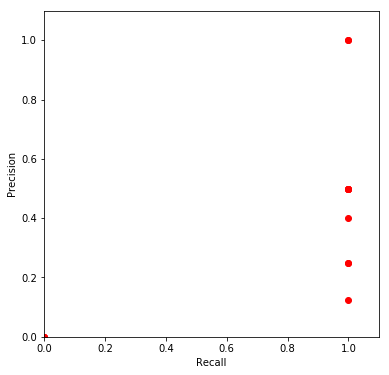

In [5]:
all_hyperparams = {
    'lsi__min_cosine_similarity_threshold' : [i/10 for i in range(6,10)],
    'lsi__svd_model__n_components':[5,10,20,50,100],
    'lsi__vectorizer__ngram_range': [(1,1), (1,2)],
    'lsi__vectorizer' : [TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True), 
                         CountVectorizer(stop_words='english')]
}

hyperparams = generate_params_comb_list(all_hyperparams)

print('Performing model optimizations...')
best_recall = 0.0
best_model = None

for i in range(0, len(thresholds)):
    for j in range(0, len(svd_model_params['n_components'])):
        for k in range(0, len(vec_params['ngram_range'])):
            for ii in range(0, len(vecs)):
                current_model = LSI()
                current_model.name = 'lsi_{}{}{}'.format(i,j,k)
                current_model.svd_model.set_params(n_components = svd_model_params['n_components'][j])
                current_model.vectorizer = vecs[ii]
                current_model.vectorizer.set_params(ngram_range = vec_params['ngram_range'][k])
                current_model.min_cosine_similarity_threshold = thresholds[i]
                current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)

                evaluator = ModelEvaluator(orc.oracle, current_model)
                evaluator.evaluate_model()

                if best_recall < evaluator.mean_recall:
                    best_recall = evaluator.mean_recall
                    best_model = current_model

                    
                    
print("------------------------ Best Model Found ------------------------------")            
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)
evaluator.plot_precision_vs_recall()

#evaluator.save_log()

{'Measures': {'Mean FScore of LSI': 0.5714285714285714,
              'Mean Precision of LSI': 0.6428571428571429,
              'Mean Recall of LSI': 0.5357142857142857},
 'Setup': [{'LSI Minimum Cosine Similarity Threshold': 0.8},
           {'SVD Model': {'algorithm': 'randomized',
                          'n_components': 100,
                          'n_iter': 10,
                          'random_state': 42,
                          'tol': 0.0}},
           {'Vectorizer': {'analyzer': 'word',
                           'binary': False,
                           'decode_error': 'strict',
                           'dtype': <class 'numpy.int64'>,
                           'encoding': 'utf-8',
                           'input': 'content',
                           'lowercase': True,
                           'max_df': 1.0,
                           'max_features': None,
                           'min_df': 1,
                           'ngram_range': (1, 1),
                

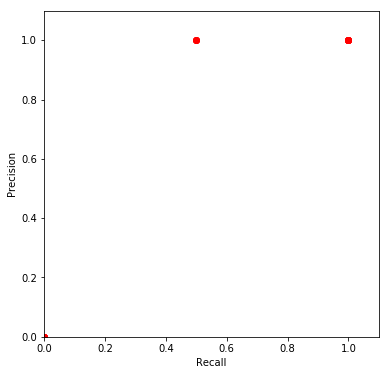

In [6]:
best_model = LSI()
best_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)
evaluator.plot_precision_vs_recall()

In [7]:
sims_1 = pd.DataFrame(np.matrix(best_model.trace_links_df))
sims_2 = pd.DataFrame(np.matrix(pairwise.cosine_similarity(best_model.get_svd_matrix(), best_model.get_query_vector()) ))

for col in sims_2.columns:
    sims_2[col] = [1 if x >= best_model.min_cosine_similarity_threshold else 0 for x in sims_2[col]]

sims_1.equals(sims_2)

True